In [611]:
#Imports 
from matplotlib import pyplot as plt
from tqdm import tqdm 
import pandas as pd 

In [612]:
#Read data
flights = pd.read_csv('../../data/Airports2.csv')

In [613]:
flights['Fly_date'] = pd.to_datetime(flights['Fly_date'])

In [614]:
flights['dstate'] = flights['Destination_city'].apply(lambda x: x[-2:])
flights['ostate'] = flights['Origin_city'].apply(lambda x: x[-2:])

In [615]:
flights['month'] = flights['Fly_date'].dt.month
flights['year'] = flights['Fly_date'].dt.year

In [617]:
# clusters_series = {'PUB': 1, 'DRO':1, 'AMK': 1, ''}

In [618]:
# Get top airports
all_airports     = pd.concat([flights['Origin_airport'], flights['Destination_airport']])
# top_airports     = list(all_airports.value_counts().head(30).index)
top_airports     = list(flights.loc[flights['dstate'].apply(lambda x: x in ['CO', 'LA']), 'Destination_airport'].unique())
airport_encoding = {airport:i for i, airport in enumerate(top_airports)}

In [619]:
# Only flights from top airports
flights = flights[flights.apply(lambda x: (x['Origin_airport'] in top_airports) and (x['Destination_airport'] in top_airports), axis=1)]

In [620]:
# Aggregate (sum) passengers, flights and distance
tmp   = flights.groupby(['Origin_airport', 'Destination_airport', 'Fly_date'])
sums  = tmp.sum().reset_index()
sums  = sums[sums['Distance'] > 0]

In [ ]:
# Filter one year of data

new_flights  = sums[['Origin_airport', 'Destination_airport', 'Fly_date', 'Passengers']]

new_flights['Fly_date'] = new_flights['Fly_date'].apply(pd.to_datetime)
# new_flights.sort_values(by=['Fly_date'], inplace=True)
new_flights.reset_index(drop=True, inplace=True)

In [644]:
one_year = new_flights[new_flights['Fly_date'].apply(lambda x: x.year == 1990)]
T = sorted(one_year['Fly_date'].unique())
date_encoding = {v:i for i, v in enumerate(T)}

## Node Positioning

Create a static adjacency matrix for the graph.


In [647]:
matrix = pd.DataFrame(0, index=top_airports, columns=top_airports)
for i in tqdm(range(len(one_year))):
    row = one_year.iloc[i]
    matrix.loc[row['Origin_airport'], row['Destination_airport']] += row['Passengers']

100%|██████████| 150/150 [00:00<00:00, 6723.15it/s]


In [648]:
#Clustering (static adjacency matrix)

from sklearn.cluster import AgglomerativeClustering, KMeans
# sc = AgglomerativeClustering(n_clusters=3)
sc = KMeans(n_clusters=2, random_state=42)
clusters = sc.fit_predict(matrix)

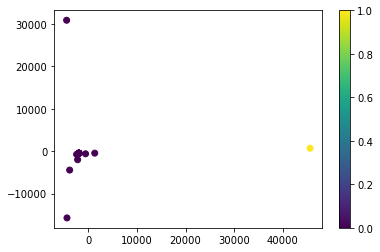

In [649]:
# Dimensionality reduction to 2-dimensional space 
# for visualization of clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(matrix)
reduced = pd.DataFrame(reduced)
plt.scatter(reduced[0], reduced[1], c=clusters);
plt.colorbar();

In [650]:
# Creating a mapping between airports and clusters

clusters_dict = dict(zip(matrix.index,clusters))
clusters_series = pd.Series(clusters_dict).sort_values()
clusters_series.name = 'cluster'

la_airs = flights.loc[flights['dstate']=='LA', 'Destination_airport'].unique()
co_airs = flights.loc[flights['dstate']=='CO', 'Destination_airport'].unique()

clusters = {air: 0 for air in la_airs}
clusters.update({air: 1 for air in co_airs})
clusters_series = pd.Series(clusters)
clusters_series.name = 'cluster'

In [651]:
# Sorting top airports by their cluster number 

top_airports.sort(key=lambda x: clusters_series.loc[x])

KeyError: 'HUM'

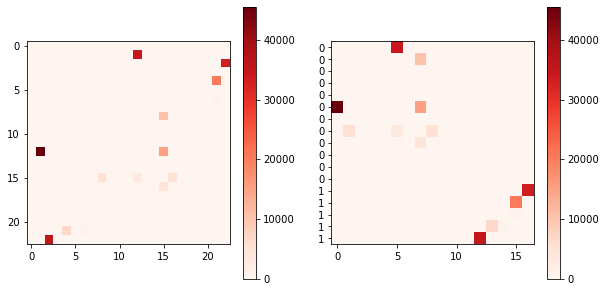

In [652]:
# Visualizing the adjacency matrix before and after sorting by clusters

fig, axs = plt.subplots(1, 2, figsize=(10,5))

img = axs[0].imshow(matrix, cmap='Reds');
fig.colorbar(img, ax=axs[0]);

matrix_2 = matrix.loc[clusters_series.index, clusters_series.index]
img = axs[1].imshow(matrix_2, cmap='Reds');
axs[1].set_yticks(range(len(matrix_2)), clusters_series.values);
fig.colorbar(img, ax=axs[1]);


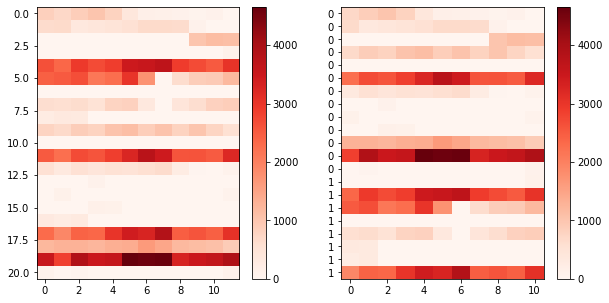

In [653]:
# Visualizing the carpet plot before and after sorting by clusters

carpet = one_year.pivot_table(index=['Origin_airport', 'Destination_airport'], \
    columns='Fly_date', values='Passengers', aggfunc='sum').fillna(0).reset_index()

carpet2 = pd.merge(clusters_series, carpet, right_on='Origin_airport', left_index=True)
carpet2 = carpet2.sort_values(['cluster', 'Origin_airport'])
carpet2.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
img = axs[0].imshow(carpet[carpet.columns[2:]], cmap='Reds', aspect='auto');
fig.colorbar(img, ax=axs[0]);
img = axs[1].imshow(carpet2[carpet.columns[3:]], cmap='Reds', aspect='auto');
# axs[1].set_yticks(carpet2.index[::10], carpet2['cluster'][::10].values);
axs[1].set_yticks(carpet2.index, carpet2['cluster'].values);
fig.colorbar(img, ax=axs[1]);

## Flights for airport grid

In [654]:
# time_steps = 12

In [655]:
one_year['Fly_date'].replace(date_encoding, inplace=True)
one_year['Fly_date'] = one_year['Fly_date'] + 1

/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_44831/85588585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year['Fly_date'].replace(date_encoding, inplace=True)
/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_44831/85588585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year['Fly_date'] = one_year['Fly_date'] + 1


In [656]:
merged  = pd.merge(one_year, clusters_series, left_on='Origin_airport', right_index=True)
merged2 = pd.merge(merged, clusters_series, left_on='Destination_airport', right_index=True, suffixes=('_origin', '_destination'))

In [657]:
cluster_stats = merged2.groupby(['cluster_origin', 'cluster_destination']).apply(\
                    lambda x: pd.Series({'size': x.size, 'sum': x['Passengers'].sum()})).reset_index()

cluster_stats.sort_values(['size'], ascending=False)

,cluster_origin,cluster_destination,size,sum
0,0,0,570,123783
3,1,1,318,97460
1,0,1,6,109
2,1,0,6,111


In [658]:
merged2.head()

,Origin_airport,Destination_airport,Fly_date,Passengers,cluster_origin,cluster_destination
151,BTR,LFT,1,830,0,0
152,BTR,LFT,2,697,0,0
153,BTR,LFT,3,867,0,0
154,BTR,LFT,4,1018,0,0
155,BTR,LFT,5,788,0,0


In [659]:
merged2.sort_values(['Passengers'], ascending=False).head(10)

,Origin_airport,Destination_airport,Fly_date,Passengers,cluster_origin,cluster_destination
2132,SHV,MLU,6,4654,0,0
2134,SHV,MLU,8,4603,0,0
2133,SHV,MLU,7,4564,0,0
2138,SHV,MLU,12,3906,0,0
2129,SHV,MLU,3,3881,0,0
1919,PUB,COS,8,3837,1,1
1330,MLU,SHV,7,3758,0,0
608,COS,PUB,8,3675,1,1
2137,SHV,MLU,11,3611,0,0
2131,SHV,MLU,5,3585,0,0


In [660]:
merged2['color'] = merged2.apply(lambda x: "red" if x['cluster_origin'] == x['cluster_destination'] else "blue", axis=1)
merged2['Origin_airport']      = merged2.apply(lambda x: "%s_%s" % (x['Origin_airport'],      x['Fly_date']), axis=1)
merged2['Destination_airport'] = merged2.apply(lambda x: "%s_%s" % (x['Destination_airport'], x['Fly_date']+1), axis=1)

In [661]:

merged2 = merged2[['Origin_airport', 'Destination_airport', 'Passengers', 'color']]
merged2.columns = ['origin', 'destination', 'count', 'color']
merged2.to_csv('flights.csv', index=False)

## Grid Positioning 

$ (t*c_x, i*c_y)$ where $i \in [0, N]$  and $t \in [0, T]$ such that $N$ is number of nodes (e.g. airports) and $T$ is time (e.g. days). 

$c_x$ and $c_y$ are constants that define the distance distance from origin $(0, 0)$ as well as between other nodes. 

In [599]:
clusters_series['MLU']

0

In [664]:
locs = []

# width = 960
# height = 600
time_steps = 12
c_x = 80
c_y = 20
# for k in airport_encoding:
    # i = airport_encoding[k]
for i, k in enumerate(clusters_series.index):
    for t in range(1, time_steps+2): #list(date_encoding.values()):
        locs.append(["%s_%s" % (k,t), (t+1)*c_x, (i+1)*c_y, clusters_series[k]])
locs_df = pd.DataFrame(locs)


In [665]:

locs_df.columns = ['iata', 'latitude', 'longitude', 'cluster']

cluster_colors = {0: "red", 1: "blue", 2: "green", 3: "yellow"}

locs_df['color'] = locs_df['cluster'].apply(lambda x: cluster_colors[x])

In [666]:
clusters_series.reset_index().groupby('cluster').apply(lambda x: list(x['index'].values))

cluster
0    [MLU, LFT, ESF, AEX, ARA, SHV, BAD, BTR, MSY, ...
1                            [PUB, DRO, MTJ, GJT, COS]
dtype: object

In [667]:


# locs_df['latitude']  = locs_df['latitude']
# locs_df['latitude']  = locs_df['latitude']
locs_df.to_csv('grid_locs.csv', index=False)